## Reduced equations for linear bending waves

The name "reduced equations for linear bending waves" comes from Lubow+Ogilvie 2000; it refers to Eqs. 8-9 in Lubow+Ogilvie 2000. This pair of coupled PDEs relates the tilt $\mathcal{W}$ and the internal torque $\mathcal{G}$:

$$ \frac{\partial \mathcal{G}}{\partial t} = \frac{\Sigma H^2 \Omega^3 R^3}4 \frac{\partial \mathcal{W}}{\partial R}  - \left( \frac{\kappa^2 - \Omega^2}{\Omega^2} \right) \frac{i\Omega}2 \mathcal{G} - \alpha \Omega \mathcal{G}, $$
$$ \frac{\partial \mathcal{W}}{\partial t} = \frac{1}{\Sigma \Omega R^3 } \frac{\partial \mathcal{G}}{\partial R} - \left(\frac{\Omega_z^2 - \Omega^2}{\Omega^2} \right) \frac{i\Omega}2 \mathcal{W}.$$

In this notebook, I'll use the setup in Zhu 2019 where he inserts a planet into the middle of a disk. We'll see (in our very simple simulation) if the disk breaks (like in Zhu 2019) or simply bends.

## Imports and normalizations

In [1]:
# %pip install fipy

# make 3D plots interactive
use_interactive_plots = False
if use_interactive_plots:
    %matplotlib notebook

import numpy as np
import pandas as pd
import tables
import time
import math
#import scipy.differentiate
import scipy.integrate as integ
import scipy.interpolate as interp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Zhu 2019 uses these parameters: $h\sim H=0.1$, $\alpha=10^{-3},10^{-2},10^{-1}$, planet at $a=1$, $M_p/M_\star=0.003,0.01$.

For the reduced equations to be valid, we require $\alpha \lesssim c_s \sim h$.

In [2]:
cs = 0.02 # 0.02
alpha = 0.01 # 0.1 # 0.019

## Numerical derivatives

In [3]:
def derivative(f, x):
    '''
    Returns first derivative of f(x) with respect to the domain x.

    '''
    
    # return scipy.differentiate.derivative(f, x)

    derivs = np.zeros(shape=f.shape)

    # handle boundaries
    derivs[0] = (f[1] - f[0]) / (x[1] - x[0])
    derivs[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])

    # central difference method
    for i in range(1, len(x)-1):
        derivs[i] = (f[i+1] - f[i-1]) / (x[i+1] - x[i-1])

    return derivs

## Disk information

Normalizations:
- $R_0 = 1$
- $\Omega_{K,0} = 1$ (so $GM = 1$)
- $\Sigma_0 = 1$
- $c_s = 0.02$ (which implies $H = c_s/\Omega \sim 0.02$)
- $\alpha = 0.019$
- Density profile: $K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2$

### Density profile

In [4]:
def Sigma(Rs, use_gap):
    '''
    Returns the disk's background surface density profile.
    If use_gap is False, do not include a gap in the profile.
    
    '''
    
    K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
    fgaps = f_gap(Rs, K, R_a, R_b, D_a, D_b, use_gap)
    
    Sigma0 = 1
    
    return Sigma0 * Rs**(-3/2) / fgaps

def f_gap(Rs, K, R_a, R_b, D_a, D_b, use_gap):
    '''
    Function that "shapes" the disk gap profile. Used in `sigma` function. 
    R_a and R_b are the locations of the inner and outer gap edges,
    D_a and D_b are the steepness of the edges, and K determines the
    depth of the gap.
    If use_gap is False, return 1 (i.e., no disk gap).
    
    '''

    if use_gap:
        return 1 + (K-1)/2 * \
            (np.tanh((Rs - R_a)/D_a) - np.tanh((Rs - R_b)/D_b))
    else:
        return 1

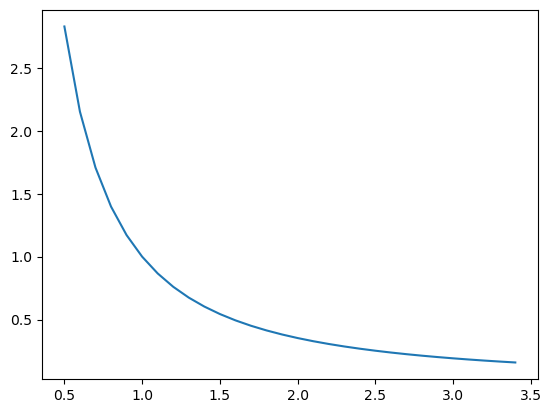

In [5]:
## check shape of disk profile
Rs_warp = np.arange(0.5, 3.5, 0.1)
K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
plt.plot(Rs_warp, Sigma(Rs_warp, False))

### Keplerian orbital frequency

Scale height, which depends on $\Omega$, is defined in the "Planet information" section below.

In [6]:
def OmegaK(Rs):
    '''
    Returns the Keplerian orbital frequency profile.
    Omega_K = sqrt(G*M_star / R^3)

    '''
    OmegaK_0 = 1 # Omega_K at R=R_0
    return OmegaK_0 * Rs**(-3/2)

## Planet information

If we insert one planet at the disk's inner boundary and one at the disk's outer boundary, can we reproduce Jiaru's results from using fixed (i.e., Dirichlet) boundary conditions?

### Laplace coefficients

In [7]:
def laplace_coeff_integrand(phi, x, j, s):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    phi: the variable that we integrate over
    x: the variable that isn't integrated over
    j, s: See Eq. 6.67 of Murray & Dermott or Eq. 21 in Lubow+Ogilvie.
    
    '''
    
    num = np.cos(j*phi) # numerator
    denom = (1 - 2 * x * np.cos(phi) + x**2) ** s
    
    return num / denom

def laplace_coeff(x, j, s):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.

    
    PARAMETERS
    ----------
    x: argument of the Laplace coefficient formula
    
    '''
    
    return 2 / np.pi * integ.quad(laplace_coeff_integrand, 0, np.pi, args=(x, j, s))[0]

Depending on whether the planet is inside ($R \gg a$; large $\alpha$) or outside ($R \ll a$; small $\alpha$) the disk, we can use the quadrupole approximations the Laplace coefficients:

In [8]:
def b0_approx(alpha, limit):
    '''
    Approximates the Laplace coefficient b^0_{3/2} as a function of 
    alpha = R/a.
    
    If alpha << 1, set `limit` to "small". If alpha >> 1, set 
    `limit` to "large".
    
    '''
    
    if limit=="small":
        return 2 
    elif limit=="large":
        return 2/alpha**3
    else:
        raise ValueError("limit must be either \"small\" or \"large.\"")

def b1_approx(alpha, limit):
    '''
    Approximates the Laplace coefficient b^1_{3/2} as a function of 
    alpha = R/a.
    
    '''
    
    if limit=="small":
        return 3*alpha 
    elif limit=="large":
        return 3/alpha**4 
    else:
        raise ValueError("limit must be either \"small\" or \"large.\"")

But if $\alpha \sim 1$, we should interpolate the Laplace coefficients:

In [9]:
# interpolate Laplace coefficient function (~10x faster)
# large alpha limit
xs_temp = np.linspace(1.001, 20, 10000)
ys_temp = [laplace_coeff(x, j=0, s=3/2) for x in xs_temp]
b0_interp_large_alpha = interp.CubicSpline(xs_temp, ys_temp)

ys_temp = [laplace_coeff(x, j=1, s=3/2) for x in xs_temp]
b1_interp_large_alpha = interp.CubicSpline(xs_temp, ys_temp)

# small alpha limit
xs_temp = np.linspace(1e-3, .99, 1000)
ys_temp = [laplace_coeff(x, j=0, s=3/2) for x in xs_temp]
b0_interp_small_alpha = interp.CubicSpline(xs_temp, ys_temp)

ys_temp = [laplace_coeff(x, j=1, s=3/2) for x in xs_temp]
b1_interp_small_alpha = interp.CubicSpline(xs_temp, ys_temp)

And let's check that our approximated functions are accurate:

In [10]:
# correctness checks
print("Correctness check: for alpha >> 1, b^1_{3/2} ~ 3/alpha^4.")
x = 1.03
print(laplace_coeff(x, j=1, s=3/2))
print(b1_approx(x,limit="large"))
print(b1_interp_large_alpha(x))

print("\nCorrectness check: for alpha >> 1, b^0_{3/2} ~ 2/alpha^3.")
x = 12
print(laplace_coeff(x, j=0, s=3/2))
print(b0_approx(x,limit="large"))
print(b0_interp_large_alpha(x))

print("\nCorrectness check: for alpha << 1, b^1_{3/2} ~ 3*alpha.")
x = .1
print(laplace_coeff(x, j=1, s=3/2))
print(b1_approx(x,limit="small"))
print(b1_interp_small_alpha(x))

print("\nCorrectness check: for alpha << 1, b^0_{3/2} ~ 2.")
x = .5
print(laplace_coeff(x, j=0, s=3/2))
print(b0_approx(x,limit="small"))
print(b0_interp_small_alpha(x))


Correctness check: for alpha >> 1, b^1_{3/2} ~ 3/alpha^4.
695.889241441088
2.6654611437470663
695.8874279636045

Correctness check: for alpha >> 1, b^0_{3/2} ~ 2/alpha^3.
0.0011756899986620154
0.0011574074074074073
0.0011756899986620146

Correctness check: for alpha << 1, b^1_{3/2} ~ 3*alpha.
0.3057081213944636
0.30000000000000004
0.3057081213944636

Correctness check: for alpha << 1, b^0_{3/2} ~ 2.
3.781491235460853
2
3.7814912354604497


### Orbital, epicyclic, and radial frequencies

(I use Eqs. 25-27 in Lubow+Ogilvie 2000.)

In [24]:
def Omega(Rs, Mp, a):
    '''
    Returns the disk's orbital frequency profile. 
    
    VARIABLES:
    ----------
    Rs is the radial domain.
    Mp is the ratio of the planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.001.
    a is the radius of the planet's orbit.

    '''

    Omegas_sq = OmegaK(Rs)**2
    alphas = Rs/a
    
    if 1 in alphas:
        raise ValueError("Can't have `a` in the list of Rs; otherwise, we have R/a = 1")

    for i in range(len(Rs)):
        R = Rs[i]
        alpha = alphas[i]
        planet_term = 0
        
        if alpha < 1:
            planet_term = Mp/(2 * a**2 * R) * (alpha*b0_interp_small_alpha(alpha) - \
                            b1_interp_small_alpha(alpha))
        elif alpha > 1:
            planet_term = Mp/(2 * a**2 * R) * (alpha*b0_interp_large_alpha(alpha) - \
                            b1_interp_large_alpha(alpha))
        Omegas_sq[i] += planet_term
    
    return np.sqrt(Omegas_sq)

def Kappa(Rs, Mp, a):
    '''
    Returns the disk's epicyclic frequency profile. 
    
    VARIABLES:
    ----------
    Rs is the radial domain.
    Mp is the ratio of the planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.001.
    a is the radius of the planet's orbit.

    '''

    kappas_sq = OmegaK(Rs)**2
    alphas = Rs/a
    
    if 1 in alphas:
        raise ValueError("Can't have `a` in the list of Rs; otherwise, we have R/a = 1")

    for i in range(len(Rs)):
        R = Rs[i]
        alpha = alphas[i]
        planet_term = 0
        
        if alpha < 1:
            planet_term = Mp/(2 * a**2 * R) * (alpha*b0_interp_small_alpha(alpha) - \
                            2*b1_interp_small_alpha(alpha))
        elif alpha > 1:
            planet_term = Mp/(2 * a**2 * R) * (alpha*b0_interp_large_alpha(alpha) - \
                            2*b1_interp_large_alpha(alpha))
        kappas_sq[i] += planet_term

    return np.sqrt(kappas_sq)

def Omega_z(Rs, Mp, a):
    '''
    Returns the disk's vertical frequency profile. 
    
    VARIABLES:
    ----------
    Rs is the radial domain.
    Mp is the ratio of the planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.001.
    a is the radius of the planet's orbit.

    '''

    Omegazs_sq = OmegaK(Rs)**2
    alphas = Rs/a
    
    if 1 in alphas:
        raise ValueError("Can't have `a` in the list of Rs; otherwise, we have R/a = 1")

    for i in range(len(Rs)):
        R = Rs[i]
        alpha = alphas[i]
        planet_term = 0
        
        if alpha < 1:
            planet_term = Mp/(2 * a**2 * R) * alpha*b0_interp_small_alpha(alpha)
        elif alpha > 1:
            planet_term = Mp/(2 * a**2 * R) * alpha*b0_interp_large_alpha(alpha)
        Omegazs_sq[i] += planet_term

    return np.sqrt(Omegazs_sq)

### Disk scale height

In [12]:
def scaleHeight(Rs):
    '''
    Returns the disk's scale height profile. We use H = c_sound / Omega_K.

    '''
    return cs / OmegaK(Rs)

In [13]:
# # spatial and time domains
# Rmin = 0.5
# Rmax = 3.5 
# Rmid = 1.5 # arbitrary point in middle of disk gap
    
# DeltaR = 0.1 # 0.03
# num_Rs = (int) ((Rmax - Rmin) / DeltaR) + 1

# # stagger W and G in the R domain
# Rs_warp = np.linspace(Rmin, Rmax, num_Rs)

# cses = scaleHeight(Rs_warp)
# plt.plot(Rs_warp, 10*cses)

# print("Courant condition: dt < ", DeltaR / max(cses))

## Integration functions

Boundary conditions:
- $\mathcal{G}(R) = 0$ at the inner and outer disk edges

Initial conditions:
- $\mathcal{W}(R_\text{min}, 0) = 0$ 
- $\mathcal{W}(R_\text{max}, 0) = 0.1$ 
- $\mathcal{W}(R,0)$ is some smooth function (eg, Gaussian integral)

### `dG_dt, dW_dt`

In [14]:
def dG_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a, use_gap):
    '''
    Returns dG/dt over the R domain (Rs_torque) for Gs.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from -1/2 to N+1/2.
    
    Mp and a are the planet's mass and orbital radius respectively.

    `use_gap` toggles if the disk's background profile has a gap.
    
    '''
    
    # validate parameters
    if (len(Rs_torque) != len(Gs)):
        raise ValueError("Rs_torque and Gs must have same length")
    if (len(Rs_warp) != len(Ws)):
        raise ValueError("Rs_warp and Ws must have same length")
    if (len(Rs_torque) != (len(Rs_warp) + 1)):
        raise ValueError("Length of Rs_torque should be (length of Rs_warp)+1")
    if (Gs[0] != 0 or Gs[-1] != 0):
        raise ValueError("First and last entries in Gs should be 0")

    # since we're changing G, compute values over G's R domain
    Sigmas = Sigma(Rs_torque, use_gap) # length N+2
    Hs = scaleHeight(Rs_torque)
    Omegas = Omega(Rs_torque, Mp, a)
    
    dW_dRs_mid = (Ws[1:] - Ws[:-1]) / (Rs_warp[1:] - Rs_warp[:-1]) # length N
    dW_dRs = np.zeros(shape=Rs_torque.shape, dtype=complex)
    dW_dRs[1:-1] = dW_dRs_mid

    # sloshing term
    slosh_term = Sigmas * (Hs**2) * (Omegas**3) * (Rs_torque**3) / 4 * dW_dRs
    # external torque term
    Kappas = Kappa(Rs_torque, Mp, a)
    ext_term = (-1) * (Kappas**2 - Omegas**2) / (Omegas**2) * (1j*Omegas/2) * Gs
    # viscous term
    visc_term = (-1) * alpha * Omegas * Gs 
    
    dG_dts = slosh_term + ext_term + visc_term
    
    return dG_dts

def dW_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a,\
          use_gap, inner_BC="None", outer_BC="None"):
    '''
    Returns dW/dt over the R domain (Rs) for Ws.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from -1/2 to N+1/2.
    
    Mp and a are the planet's mass and orbital radius respectively.

    `use_gap` toggles if the disk's background profile has a gap.
    
    `inner_BC` and `outer_BC` determine the boundary conditions (BCs). The possible
    values are:
    1. "None": No BC.
    2. "Dirichlet": W=constant.
    3. "Neumann": dW_dR=0.

    '''

    # validate parameters
    if (len(Rs_torque) != len(Gs)):
        raise ValueError("Rs_torque and Gs must have same length")
    if (len(Rs_warp) != len(Ws)):
        raise ValueError("Rs_warp and Ws must have same length")
    if (len(Rs_torque) != (len(Rs_warp) + 1)):
        raise ValueError("Length of Rs_torque should be (length of Rs_warp)+1") 
    if (Gs[0] != 0 or Gs[-1] != 0):
        raise ValueError("First and last entries in Gs should be 0")
        
    # since we're changing W, compute values over W's R domain
    Sigmas = Sigma(Rs_warp, use_gap) # length N+1
    Omegas = Omega(Rs_warp, Mp, a)
    
    # defines dG_dR for the W indices 0 through N
    dG_dRs = (Gs[1:] - Gs[:-1]) / (Rs_torque[1:] - Rs_torque[:-1]) # length N+1
    
    # internal torquing term
    int_term = dG_dRs / (Sigmas * Omegas * Rs_warp**3)
    # external torque term
    Omega_zs = Omega_z(Rs_warp, Mp, a)
    ext_term = (-1) * (Omega_zs**2 - Omegas**2) / (Omegas**2) * (1j*Omegas/2) * Ws

    dW_dts = int_term + ext_term
    
    # enforce boundary conditions
    if inner_BC=="Dirichlet":
        dW_dts[0] = 0 
    elif inner_BC=="Neumann": # set W[0] equal to W[1]
        dW_dts[0] = (dW_dts[1] + Ws[1]) - Ws[0]
    elif inner_BC != "None":
        raise ValueError("inner_BC must be \"Dirichlet\", \"Neumann\", or \"None\"")
    
    if outer_BC=="Dirichlet":
        dW_dts[-1] = 0 
    elif outer_BC=="Neumann": # set W[-1] equal to W[-2]
        dW_dts[-1] = (dW_dts[-2] + Ws[-2]) - Ws[-1]
    elif outer_BC != "None":
        raise ValueError("outer_BC must be \"Dirichlet\", \"Neumann\", or \"None\"")
    
    return dW_dts

### `evolve_WG`

In [15]:
def evolve_WG(Rs_torque, Gs, Rs_warp, Ws, dt, Mp, a, \
             use_gap, inner_BC="None", outer_BC="None"):
    '''
    Use the leapfrog method to evolve W(R) and G(R) forward by one timestep (dt).
    W and G are staggered in the R domain; see `dG_dt' or `dW_dt' function.
    Returns the updated W and G arrays.
    
    Mp and a are the inner planet's mass and orbital radius respectively.

    `use_gap` toggles if the disk's background profile has a gap.
    
    `inner_BC` and `outer_BC` determine the boundary conditions (BCs). The possible
    values are:
    1. "None": No BC.
    2. "Dirichlet": W=constant.
    3. "Neumann": dW_dR=0.
    
    '''

    # 1. Advance Gs slightly forward in time
    G_halfs = Gs + (dt/2)*dG_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a, use_gap)

    # 2. Advance Ws in time using the "intermediate" G values
    W_nexts = Ws + dt*dW_dt(Rs_torque, G_halfs, Rs_warp, Ws, Mp, a,\
          use_gap, inner_BC="None", outer_BC="None")

    # 3. Advance G_halfs in time using the updated Ws
    G_nexts = G_halfs + (dt/2)*dG_dt(Rs_torque, G_halfs, Rs_warp, W_nexts, Mp, a, use_gap)

    return W_nexts, G_nexts

### `integrate`

In [16]:
def integrate(Rs_torque, Gs, Rs_warp, Ws, ts, Mp, a,\
          use_gap, inner_BC="None", outer_BC="None"):
    '''

    Integrate W(R) and G(R) over a given time domain (ts). Returns W(R) and 
    G(R) at the final timestep.
    
    W and G are staggered in the R domain; see `dG_dt' or `dW_dt' function.
    
    Mp and a are the planet's mass and orbital radius respectively.

    `use_gap` toggles if the disk's background profile has a gap.
    
    If `inner_Neumann` is True, ensures that dW_dR=0 at the inner boundary 
    (ie, at R_min). Else, we do not change W at R_min (this is equivalent to 
    a Dirichlet boundary condition).
    The same is true for `outer_Neumann`, except applied to the outer boundary.
    See `dW_dt` function.

    '''

    # save W at different timepoints
    W_tseries = pd.DataFrame(columns=Rs_warp, dtype=complex)
    W_tseries.loc[ts[0]] = Ws.astype(complex)
    
    # at each t, save the tilt at the middle of the R domain
    Wmids = np.empty_like(ts, dtype=complex)
    
    for i in range(len(ts)-1):
        t = ts[i]
        dt = ts[i+1] - ts[i]
        Wnexts, Gnexts = evolve_WG(Rs_torque, Gs, Rs_warp, Ws, dt, Mp, a, use_gap)

        Ws, Gs = Wnexts, Gnexts 
        Wmids[i] = np.take(Ws, Ws.size // 2)
        
        if (i % 100 == 0):
            W_tseries.loc[t] = Ws.astype(complex)

    return Ws, Gs, Wmids, W_tseries

## Run a sim

Note that, from the $\frac{\partial \mathcal{G}}{\partial t} = \frac{\Sigma H^2 \Omega^3 R^3}4 \frac{\partial \mathcal{W}}{\partial R}  - \alpha \Omega G$, we can see that $t \sim \Omega^{-1} h^{-1}$ and $t \sim \Omega^{-1} \alpha^{-1} $ are both relevant timescales. This corresponds to $\sim$10-100 $\Omega^{-1}$.

In [134]:
# planet parameters
Mp, a = 0.003, 1
# toggle disk gap
use_gap = False

# spatial and time domains
Rmin = 0.5
Rmax = 3.5 
    
DeltaR = 0.21 # 0.03
num_Rs = (int) ((Rmax - Rmin) / DeltaR) + 1

# stagger W and G in the R domain
Rs_warp = np.linspace(Rmin, Rmax, num_Rs)
#Rs_warp = np.delete(Rs_warp, np.searchsorted(Rs_warp, a)) # exclude R=1 point
#Rs_torque = np.zeros(shape=((num_Rs))) # exclude R=1 point
Rs_torque = np.zeros(shape=((num_Rs+1)))
Rs_torque[0] = Rs_warp[0] - DeltaR/2
Rs_torque[1:] = Rs_warp.copy() + DeltaR/2

tmin = 0
tmax = 300
Deltat = 1 # 0.03
num_ts = (int) ((tmax - tmin) / Deltat) + 1
ts = np.linspace(tmin, tmax, num_ts)

# disk that's initially flat but tilted
#Ws_init = np.zeros(shape=Rs_warp.shape, dtype=complex) + 0.1
#Ws_init.astype(complex)

# disk that's initially flat
Ws_init = 0.1 + np.zeros(shape=((num_Rs)))
# Ws_init = 0.1 * np.cumsum(np.exp(-(Rs_warp-2)**2 / 2) / np.sqrt(2*np.pi)) * DeltaR # warped disk
Ws_init.astype(complex)

Wmids = np.empty_like(Ws_init, dtype=complex)

#Ws = np.zeros(shape=Rs.shape) + (Rs-0.5)/30 # tilt W(R)
Gs_init = np.zeros(shape=Rs_torque.shape) # torque G(R)
Gs_init = Gs_init.astype(complex)

In [135]:
# set boundary conditions
inner_BC = "None"
outer_BC = "None"

resume_sim = False

start = time.time()

if resume_sim:
    ## use below line if you want to use a previous sim's results
    Ws_final, Gs_final, Wmids, W_tseries = integrate(Rs_torque, Gs_final, Rs_warp, Ws_final, ts, Mp, a,\
                use_gap, inner_BC, outer_BC)
    #tstop += tmax
else:
    Ws_final, Gs_final, Wmids, W_tseries = integrate(Rs_torque, Gs_init, Rs_warp, Ws_init, ts, Mp, a,\
                use_gap, inner_BC, outer_BC)
    tstop = tmax


end = time.time()
print("Elapsed time:", np.round(end - start, 2))

Elapsed time: 0.29


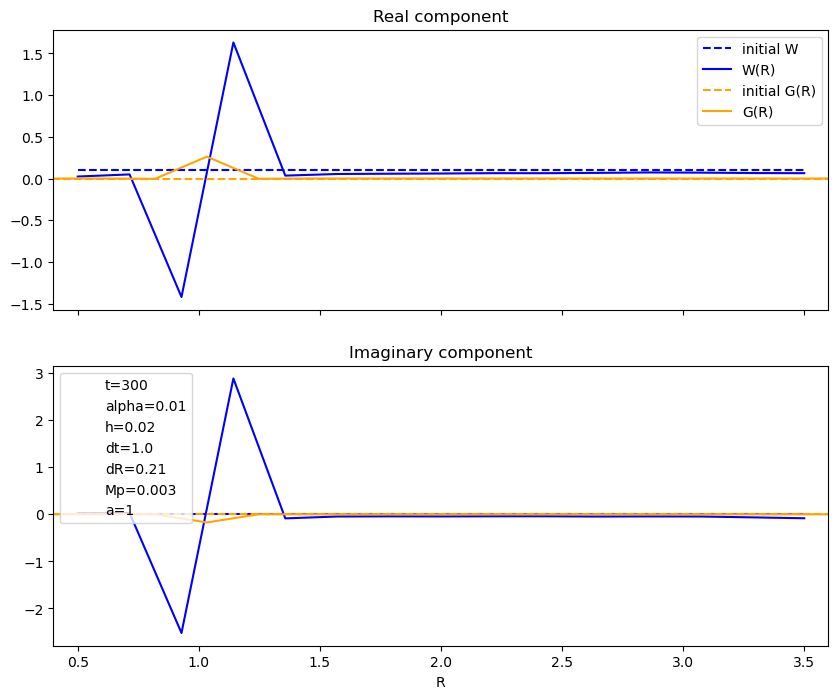

In [136]:
fig, axs = plt.subplots(2, sharex=True, figsize=(10,8))
fig.set_facecolor("white")

axs[0].plot(Rs_warp, Ws_init.real, c="blue", ls="--", label="initial W")
axs[0].plot(Rs_warp, Ws_final.real, c="blue", label="W(R)")
axs[0].plot(Rs_torque, Gs_init.real, c="orange", ls="--", label="initial G(R)")
axs[0].plot(Rs_torque, Gs_final.real, c="orange", label="G(R)")

ymin, ymax= min(min(Ws_init.real), min(Ws_final.real)) - .01, max(max(Ws_init.real), max(Ws_final.real)) + .01
if use_gap:
    R_a, R_b = 1, 2
    axs[0].vlines(R_a, ymin, ymax, color="black", linestyle=":")
    axs[0].vlines(R_b, ymin, ymax, color="black", linestyle=":", label="Gap edges")

#axs[0].set_ylim(ymin,ymax)

axs[1].scatter([],[], s=0, label="t=" + str(max(tstop,tmax)))
axs[1].scatter([],[], s=0, label="alpha=" + str(alpha))
axs[1].scatter([],[], s=0, label="h=" + str(cs))
#axs[1].scatter([],[], s=0, label="BCs: G=0")
dt = np.round(ts[1] - ts[0],3)
axs[1].scatter([],[], s=0, label="dt="+str(dt))
axs[1].scatter([],[], s=0, label="dR="+str(DeltaR))
axs[1].scatter([],[], s=0, label="Mp=" + str(Mp))
axs[1].scatter([],[], s=0, label="a=" + str(a))

axs[0].legend()
axs[0].set_title("Real component")

axs[1].plot(Rs_warp, Ws_init.imag, c="blue", ls="--")#, label="initial W")
axs[1].plot(Rs_warp, Ws_final.imag, c="blue")#, label="W(R)")
axs[1].plot(Rs_torque, Gs_init.imag, c="orange", ls="--")#, label="initial G(R)")
axs[1].plot(Rs_torque, Gs_final.imag, c="orange")#, label="G(R)")

ymin, ymax= min(Ws_final.imag) - .01, max(max(Ws_init.imag),max(Ws_final.imag)) + .01
if use_gap:
    R_a, R_b = 1, 2
    axs[1].vlines(R_a, ymin, ymax, color="black", linestyle=":")
    axs[1].vlines(R_b, ymin, ymax, color="black", linestyle=":")#, label="Gap edges")

axs[1].set_xlim(Rmin - 0.1, Rmax + 0.1)
#axs[1].set_ylim(ymin,ymax)

axs[1].legend()
axs[1].set_title("Imaginary component")

axs[1].set_xlabel("R")

save_figs = True

if save_figs:
    filepath = "Figures/t=" + str(tmax) + ".png"
    plt.savefig(filepath)

plt.show()

In [39]:
# check how much the disk has flattened (ratio should be ~1e-2)

Wdiff_ratio = (max(Ws_final) - min(Ws_final)) / (Ws_init[-1] - Ws_init[0])
print("Ratio of final W difference to initial: {:.2E}".format(Wdiff_ratio.real))

# dW_init = max(W_tseries.loc[0].values) - min(W_tseries.loc[0].values)
# dW_final = max(W_tseries.loc[1300].values) - min(W_tseries.loc[1300].values)
# dW_final / dW_init

Ratio of final W difference to initial: 2.37E-10


### load or save data

In [75]:
file_path = "Data/W_tseries/zhu-inspired/alpha=" + str(alpha) + ",h=" + str(cs) + \
                ",Mp=" + str(Mp) + ",a=" + str(a) + ".h5"

# temp = pd.read_hdf(file_path, key='W_tseries', mode='r')
save_data = True
if save_data:
    if resume_sim:
        W_tseries.to_hdf(file_path, key='W_tseries', mode='a', append=True, index=True) # `mode=a` means appending (or writing if file is new)
    else:
        W_tseries.to_hdf(file_path, key='W_tseries', mode='w', append=False, index=True)

In [41]:
file_path0 = "Data/W_tseries/alpha=0.01,h=0.02_noGap_dt=0.1_leapfrog.h5"

W_tseries0 = pd.read_hdf(file_path0, key='W_tseries', mode='r')

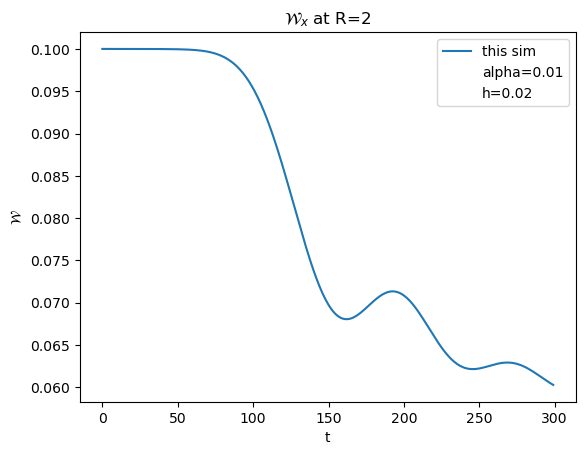

In [137]:
fig = plt.figure()
fig.set_facecolor("white")

# plot results of one sim
#plt.plot(temp.index[::], temp[2].values.real[::], label="saved W_x")
plt.plot(ts[0:-1], Wmids.real[0:-1], label="this sim")
#plt.plot(ts[0:-1:100], Wmids.imag[0:-1:100], label="W_y")

# compare results from multiple sims
#plt.plot(W_tseries0.index, W_tseries0[2].values.real, label="dR=0.1")
# plt.plot(W_tseries1.index, W_tseries1[2].values.real, label="dt=0.1")
# plt.plot(W_tseries2.index, W_tseries2[2].values.real, label="dt=0.2")
# plt.plot(W_tseries3.index, W_tseries3[2].values.real, label="dt=0.3")

plt.scatter([],[], s=0, label="alpha=" + str(alpha))
plt.scatter([],[], s=0, label="h=" + str(cs))
#plt.scatter([],[], s=0, label="BCs: G=0")
# plt.scatter([],[], s=0, label="dt=" + str(dt))

plt.xlabel("t")
plt.ylabel(r"$\mathcal{W}$")
#plt.ylim(0.02, 0.06)

plt.title(r"$\mathcal{W}_x$ at R=2")
plt.legend()

if save_figs:
    plt.savefig("Figures/Wmid_evoln_t=" + str(max(tmax,tstop)) + ".png")

plt.show()


## Compare to steady-state solution

### plug into PDEs

In [ ]:
fig = plt.figure(figsize=(6,4))
fig.set_facecolor("white")

dWdts_init = dW_dt(Rs_torque, Gs_init, Rs_warp, Ws_init, Mp_in, a_in, Mp_out, a_out, \
       inner_BC, outer_BC)

plt.plot(Rs_warp, np.abs(dWdts_init), label="init")

dWdts_final = dW_dt(Rs_torque, Gs_final, Rs_warp, Ws_final, Mp_in, a_in, Mp_out, a_out, \
       inner_BC, outer_BC)

plt.plot(Rs_warp, np.abs(dWdts_final), label="final")

plt.scatter([],[], s=0, label="t=" + str(tstop))

plt.xlabel("R")
plt.yscale("log")
plt.title("|dW/dt|")

plt.legend()
if save_figs:
    filepath = "Figures/dWdt_t=" + str(tstop) + ".png"
    plt.savefig(filepath)
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,4))
fig.set_facecolor("white")

dGdts_init = dG_dt(Rs_torque, Gs_init, Rs_warp, Ws_init, Mp_in, a_in, Mp_out, a_out)

plt.plot(Rs_torque, np.abs(dGdts_init), label="init")

dGdts_final = dG_dt(Rs_torque, Gs_final, Rs_warp, Ws_final, Mp_in, a_in, Mp_out, a_out)

plt.plot(Rs_torque, np.abs(dGdts_final), label="final")

plt.scatter([],[], s=0, label="t=" + str(tstop))

plt.xlabel("R")
plt.yscale("log")
plt.title("|dG/dt|")

plt.legend()
if save_figs:
    filepath = "Figures/dGdt_t=" + str(tstop) + ".png"
    plt.savefig(filepath)
plt.show()

### compare to dW/dR

In [ ]:
# check that, if Neumann conditions are on, W changes at boundaries
# print(Ws[0] - Ws_final[0])
# print(Ws[-1] - Ws_final[-1])

In [ ]:
#Gs_final[-1]

In [ ]:
#plt.plot(Gs_final)

In [ ]:
def dW_dR_ss(Rs):
    '''
    Computes the steady-state value of dW_dR. Assumes no external torque, 
    so we can write G(R) = constant.
    
    '''
    
    return alpha * Omega(Rs_warp) * Gs_final[-1] / \
            (Sigma(Rs) * scaleHeight(Rs)**2 * Omega(Rs)**3 * Rs**3 / 4)


# fig = plt.figure()
# fig.set_facecolor("white")

# plt.plot(Rs_warp, np.gradient(Ws_final, Rs_warp), label="sim")
# # in steady-state, G should be constant
# plt.plot(Rs_warp, dW_dR_ss(Rs_warp), label="steady state")

# plt.scatter([],[], s=0, label="t=" + str(tmax))
# plt.scatter([],[], s=0, label="alpha=" + str(alpha))

# plt.title("dW/dR")
# plt.legend()

## Visualize in 3D

Given the tilt $\mathcal{W}(R)$, visualize the disk in 3D space.

In [ ]:
def plot_disk(Ws, Rs_warp):
    '''
    Given values of the tilt variable W over the domain Rs_warp, 
    plot the disk shape in 3D space.
    
    '''
    
    fig = plt.figure(figsize=(6,6))
    fig.set_facecolor("white")

    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    maxcoord = 3.6
    zlim = 1
    ax.set_xlim(-maxcoord, maxcoord)
    ax.set_ylim(-maxcoord, maxcoord)
    ax.set_zlim(-zlim, zlim)
    
    lxs = Ws.real
    lys = Ws.imag
    
    thetas = np.linspace(0, 2*np.pi, num=50)
    thetas = np.reshape(thetas, (1, len(thetas)))
    
    # plot each ring separately
    for i in range(len(Rs_warp)):
        R = Rs_warp[i]
        lx = lxs[i]
        ly = lys[i]
        
        # 
        a_vec = np.array((-ly, lx, 0)) / np.sqrt(lx**2 + ly**2) # normalize
        a_vec = np.reshape(a_vec, (3, 1))
        
        b_vec = np.array((-lx, -ly, lx**2 + ly**2)) / np.sqrt(2*lx**2 + 2*ly**2)
        b_vec = np.reshape(b_vec, (3, 1))
        
        coords = R * (a_vec*np.cos(thetas) + b_vec*np.sin(thetas))
        ax.plot(coords[0], coords[1], coords[2], alpha=0.8, color="gray")
        
    plt.title("Disk visualization")
    plt.show()
    

In [ ]:
start = time.time()
plot_disk(Ws_final, Rs_warp)
end = time.time()
print("Elapsed time:", np.round(end - start, 2))